In [1]:
!python --version

Python 3.8.5


In [2]:
%%bash
pwd

/mnt/c/Users/amit/OneDrive/MU/Federated Learning with Mobile Edge Devices/pramitd/PyHessian_AdaHessian_RiseCamp-main


In [3]:
!pip install numpy

In [4]:
!pip install matplotlib

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89


In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
#import torch

import helper

import matplotlib.pyplot as plt

In [9]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
print(labels)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([1, 5, 7, 3, 1, 5, 9, 5, 7, 0, 9, 6, 4, 1, 7, 3, 9, 2, 3, 4, 6, 9, 1, 4,
        3, 9, 4, 6, 7, 6, 0, 3, 7, 9, 6, 1, 6, 7, 3, 5, 7, 9, 7, 4, 7, 1, 7, 1,
        6, 5, 2, 7, 8, 4, 9, 9, 3, 1, 4, 2, 4, 5, 3, 6])


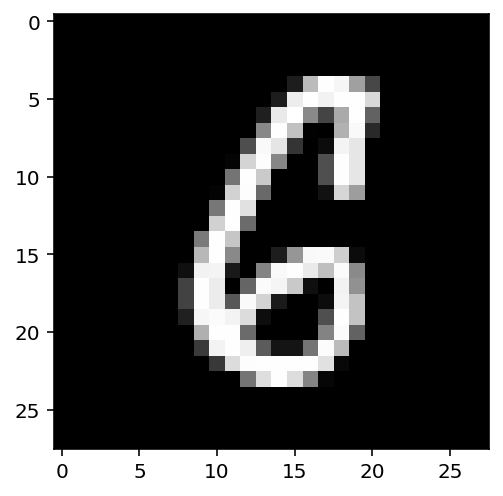

In [11]:
plt.imshow(images[63].numpy().squeeze(), cmap='Greys_r');

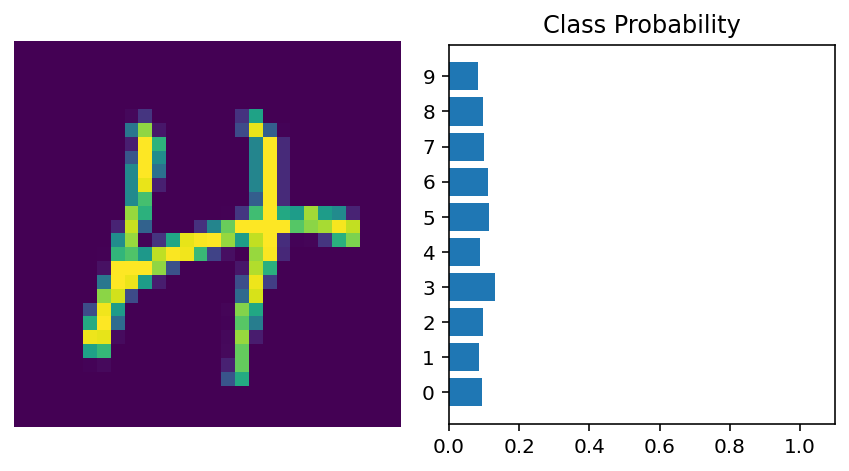

In [12]:
from torch import nn
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = torch.exp(model.forward(images[0,:]))
helper.view_classify(images[0].view(1, 28, 28), ps)

In [13]:
#from torch import optim
#optimizer = optim.SGD(model.parameters(), lr = 0.01)

from adahessian import AdaHessian
optimizer = AdaHessian(model.parameters(), lr = 0.01)

In [14]:
import time
start_time = time.time()
model = model.to(device)
epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward(create_graph = True)
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                images = images.view(images.shape[0], -1)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
print("--- %s seconds ---" % (time.time() - start_time))

Epoch: 1/5..  Training Loss: 0.532..  Test Loss: 0.308..  Test Accuracy: 0.911
Epoch: 2/5..  Training Loss: 0.297..  Test Loss: 0.256..  Test Accuracy: 0.924
Epoch: 3/5..  Training Loss: 0.240..  Test Loss: 0.214..  Test Accuracy: 0.937
Epoch: 4/5..  Training Loss: 0.197..  Test Loss: 0.177..  Test Accuracy: 0.945
Epoch: 5/5..  Training Loss: 0.166..  Test Loss: 0.148..  Test Accuracy: 0.955
--- 98.29327154159546 seconds ---


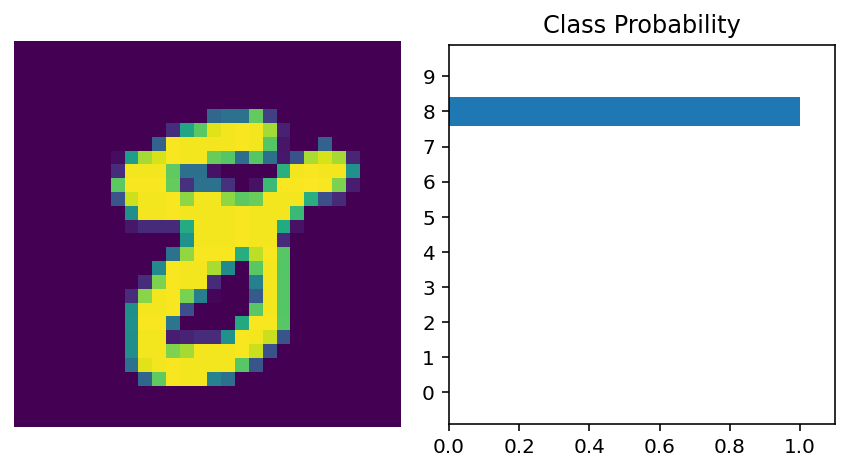

In [15]:
# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilities (softmax) for img
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
ps = ps.cpu()
# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28).cpu(), ps)

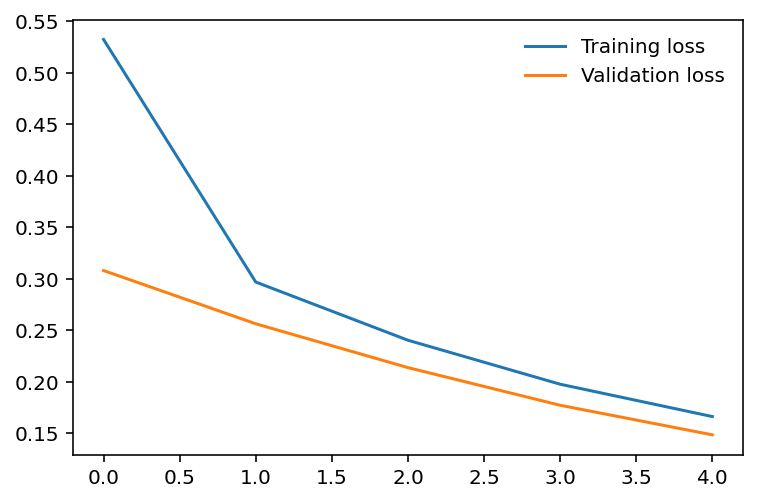

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [17]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [18]:
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)

In [19]:
# Saving the model
torch.save(model.state_dict(), 'checkpoint.pth')

In [20]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [21]:
# Loading the trained model into the network
model.load_state_dict(state_dict)

<All keys matched successfully>

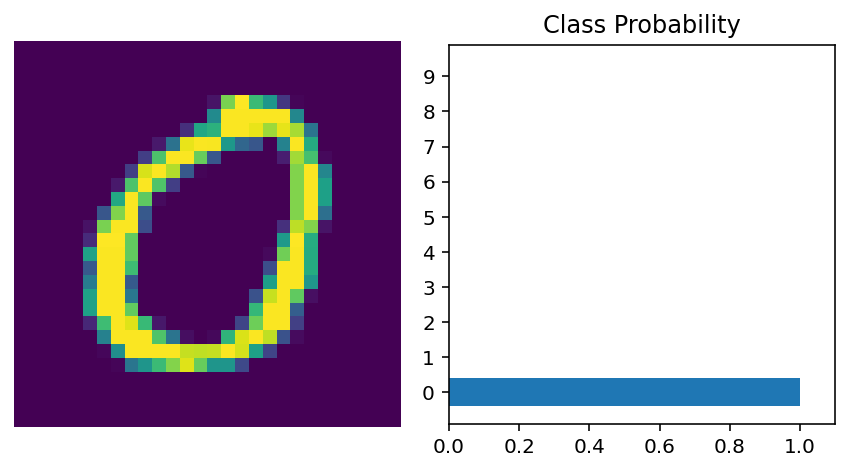

In [22]:
# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilities (softmax) for img
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
ps = ps.cpu()
# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28).cpu(), ps)

In [23]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [24]:
params=[]
for param in model.parameters():
    params.append(param)

In [25]:
params

[Parameter containing:
 tensor([[-0.0207,  0.0363,  0.0302,  ...,  0.0166, -0.0202,  0.0265],
         [-0.0115, -0.0128,  0.0238,  ...,  0.0134, -0.0053, -0.0111],
         [ 0.0252,  0.0250,  0.0225,  ..., -0.0103,  0.0200, -0.0197],
         ...,
         [-0.0535, -0.0120,  0.0043,  ..., -0.0155, -0.0297, -0.0141],
         [-0.0062,  0.0054, -0.0290,  ...,  0.0083,  0.0140,  0.0187],
         [ 0.0370, -0.0211, -0.0129,  ...,  0.0274,  0.0319, -0.0066]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 1.5229e-02,  3.0257e-02, -3.8846e-02, -2.7133e-02,  2.8496e-02,
          1.1048e-02,  1.7161e-02, -1.5924e-02, -6.2381e-04, -1.1155e-01,
          2.7961e-02,  5.9993e-04, -1.5113e-02,  8.6128e-03,  2.6665e-03,
          2.6618e-02, -3.4123e-02,  6.6860e-03, -3.2012e-03,  3.5334e-02,
         -2.5860e-02,  2.9812e-02, -3.2493e-03,  4.2419e-02,  2.4958e-02,
         -1.0262e-02,  2.3261e-02,  9.1047e-05,  1.7508e-02,  3.1319e-02,
         -1.9052e-02, -